<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/predicting_medical_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchviz

In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import numpy as np

In [3]:
def load_and_preprocess_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]:
    """Load and preprocess the training and testing data.

    Args:
        train_path (str): The file path for the training data CSV.
        test_path (str): The file path for the testing data CSV.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]: A tuple containing the training DataFrame,
        the testing DataFrame, and the fitted LabelEncoder.
    """
    try:
        # Load the data
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        # Check if necessary columns exist
        if 'prognosis' not in train_df.columns or 'prognosis' not in test_df.columns:
            raise ValueError("The 'prognosis' column is missing from the datasets.")
        if 'symptoms' not in train_df.columns or 'symptoms' not in test_df.columns:
            raise ValueError("The 'symptoms' column is missing from the datasets.")

        # Initialize and fit the LabelEncoder
        label_encoder = LabelEncoder()
        train_df['prognosis'] = label_encoder.fit_transform(train_df['prognosis'])
        test_df['prognosis'] = label_encoder.transform(test_df['prognosis'])

        return train_df, test_df, label_encoder

    except FileNotFoundError as e:
        print(f"Error: {e}")
        raise
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        raise
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [4]:
# Load and preprocess data
train_df, test_df, label_encoder = load_and_preprocess_data("/content/drive/MyDrive/Training.csv", "/content/drive/MyDrive/Testing.csv")

In [5]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 41


In [6]:
MODEL_NAME = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_classes, output_attentions=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model che

Using device: cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
class CustomTextDataset(Dataset):
    """Custom Dataset class for text data."""

    def __init__(self, dataframe: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        """
        Initializes the dataset with the DataFrame, tokenizer, and max length.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the symptoms and prognosis.
            tokenizer (AutoTokenizer): Tokenizer for the specific transformer model.
            max_length (int): Maximum length of the tokenized input.
        """
        self.tokenizer = tokenizer
        self.texts = dataframe['symptoms'].astype(str).tolist()  # Convert to list for easier indexing
        self.labels = dataframe['prognosis'].values
        self.max_length = max_length

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        """Generates one sample of data."""
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"  # Returns PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the extra dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove the extra dimension
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        }


In [9]:
def create_data_loaders(train_df: pd.DataFrame, test_df: pd.DataFrame, tokenizer: AutoTokenizer, batch_size: int = 16) -> Tuple[DataLoader, DataLoader]:
    """Create DataLoaders for training and testing."""
    train_dataset = CustomTextDataset(train_df, tokenizer, max_length=512)
    test_dataset = CustomTextDataset(test_df, tokenizer, max_length=512)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [10]:
# Create data loaders
train_loader, test_loader = create_data_loaders(train_df, test_df, tokenizer)

In [11]:
def train_model(model: AutoModelForSequenceClassification, train_loader: DataLoader, num_epochs: int = 3):
    """Train the model."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)  # Move to the same device as the model
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            try:
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            except RuntimeError as e:
                print(f"Error during forward pass: {e}")
                continue

            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [12]:
# Train the model
train_model(model, train_loader)

Epoch 1/3, Loss: 2.3431
Epoch 2/3, Loss: 0.3611
Epoch 3/3, Loss: 0.0976


In [14]:
def evaluate_model(model: AutoModelForSequenceClassification, test_loader: DataLoader, label_encoder: LabelEncoder):
    """Evaluate the model."""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)


In [16]:
# Evaluate the model
evaluate_model(model, test_loader, label_encoder)

Accuracy: 1.0000
Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        25
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        25
                            Common Cold       1.00      1.00      1.

In [17]:
def get_predictions_with_probabilities(text: str, model: AutoModelForSequenceClassification, tokenizer: AutoTokenizer, label_encoder: LabelEncoder) -> Tuple[str, np.ndarray]:
    """Get predictions with probabilities for a given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)

    predicted_class = probs.argmax(dim=-1).item()
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label, probs.cpu().numpy()[0]

In [18]:
# Example usage of prediction and attention visualization
text_example = "Patient reports severe headache and chest pain."
label, prob = get_predictions_with_probabilities(text_example, model, tokenizer, label_encoder)
print(f"Predicted prognosis: {label}, Probabilities: {prob}")

Predicted prognosis: Hypertension , Probabilities: [0.00824441 0.00776197 0.00960834 0.00135772 0.01289454 0.00774167
 0.00725753 0.0108633  0.00548325 0.00552016 0.00153788 0.00346068
 0.00276865 0.00107704 0.0072088  0.00886705 0.00491217 0.01107866
 0.03552369 0.00148218 0.00987323 0.00222235 0.00220297 0.7207327
 0.00287635 0.00378529 0.00144132 0.00560184 0.00383224 0.02185659
 0.00517355 0.00461145 0.02829811 0.00536615 0.00504174 0.00332124
 0.00256899 0.00485642 0.00314633 0.004836   0.00370551]


In [19]:
def plot_attention_scores(text: str, model: AutoModelForSequenceClassification, tokenizer: AutoTokenizer, layer_num: int = 0, head_num: int = 0):
    """Plot attention scores for a given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[layer_num][0, head_num].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(10, 8))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='coolwarm')
    plt.title(f'Attention scores (Layer {layer_num}, Head {head_num})')
    plt.show()

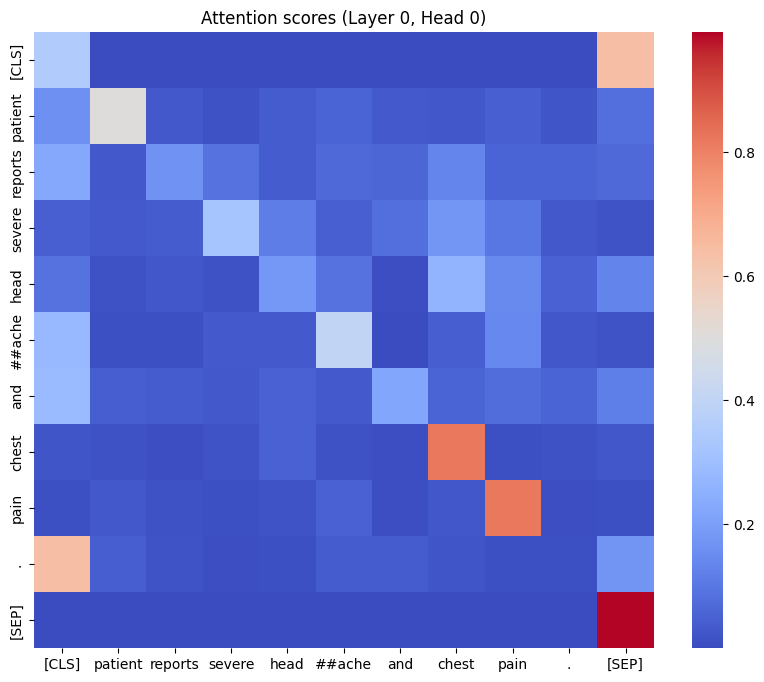

In [20]:
plot_attention_scores(text_example, model, tokenizer)

In [24]:
# Specify the paths for saving the model and tokenizer
model_save_path = "/content/drive/MyDrive/MT/trained_clinicalbert_model"
tokenizer_save_path = '/content/drive/MyDrive/MT/trained_clinicalbert_tokenizer'

# Saving the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved locally!")

Model and tokenizer saved locally!
